# Siamese Neural Network - omniglot dataset

## Import Library

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Input, backend
import tensorflow_datasets as tfds

## Load the Omniglot dataset 

In [10]:
(ds_train, ds_test), ds_info = tfds.load('omniglot', split=['train','test'], with_info=True, shuffle_files=True)

In [3]:
input_shape = ds_info.features['image'].shape
print(input_shape)

(105, 105, 3)


In [4]:
print(list(ds_info.features.keys()))

['image', 'alphabet', 'alphabet_char_id', 'label']


In [5]:
ds_info.splits['train'].num_examples

19280

## Split the dataset to train and test

In [11]:
num = int(ds_info.splits['train'].num_examples / 2)
left = ds_train.take(num)
right = ds_train.skip(num).take(num)
ds_train = tf.data.Dataset.zip((left, right))

def normalize_img(left, right):
  """Normalizes images: `uint8` -> `float32`."""
  # left, right = case
  if left["alphabet"] == right["alphabet"]:
    flag = 0
  else:
    flag = 1
  return [tf.cast(left["image"], tf.float32) / 255., tf.cast(right["image"], tf.float32) / 255.], flag



In [12]:
ds_train

<ZipDataset shapes: ({alphabet: (), alphabet_char_id: (), image: (105, 105, 3), label: ()}, {alphabet: (), alphabet_char_id: (), image: (105, 105, 3), label: ()}), types: ({alphabet: tf.int64, alphabet_char_id: tf.int64, image: tf.uint8, label: tf.int64}, {alphabet: tf.int64, alphabet_char_id: tf.int64, image: tf.uint8, label: tf.int64})>

In [13]:
# def normalize_img(case):
#   """Normalizes images: `uint8` -> `float32`."""
#   return tf.cast(case["image"], tf.float32) / 255., case["alphabet"]



ds_train = ds_train.map(
  normalize_img, num_parallel_calls=tf.data.experimental.AUTOTUNE)
ds_train = ds_train.cache()
ds_train = ds_train.shuffle(int(ds_info.splits['train'].num_examples/2))
ds_train = ds_train.batch(128)
ds_train = ds_train.prefetch(tf.data.experimental.AUTOTUNE)

In [ ]:
ds_test = ds_test.map(
    normalize_img, num_parallel_calls=tf.data.experimental.AUTOTUNE)
ds_test = ds_test.batch(128)
ds_test = ds_test.cache()
ds_test = ds_test.prefetch(tf.data.experimental.AUTOTUNE)

In [15]:
def triplet_loss(y_true, y_pred, margin = 0.4):
    """Implementation of the triplet loss function

    Arguments:
        y_true : true labels, required when you define a loss in Keras, 
                not applied in this function.

        y_pred (list): python list containing three objects:
            anchor : the encodings for the anchor data
            positive : the encodings for the positive data (similar to anchor)
            negative : the encodings for the negative data (different from anchor)
        
        margin (float, optional): m > 0 determines how far the embeddings of 
                    a negative data should be pushed apart. Defaults to 0.4.

    Returns:
        loss (float): real number, value of the loss
    """

    anchor = y_pred[0]
    positive = y_pred[1]
    negative = y_pred[2]

    # squared distance between the anchor and the positive
    pos_dist = tf.math.reduce_sum(tf.math.square(anchor - positive), axis=1)

    # squared distance between the anchor and the negative
    neg_dist = tf.math.reduce_sum(tf.math.square(anchor - negative), axis=1)

    # compute loss
    basic_loss = margin + pos_dist - neg_dist
    loss = tf.math.maximum(basic_loss,0.0)
    loss = tf.math.reduce_mean(loss)
    return loss


def contrastive_loss(y_true, y_pred, margin = 0.4):
    """Implementation of the triplet loss function

    Inspired by https://stackoverflow.com/questions/38260113/implementing-contrastive-loss-and-triplet-loss-in-tensorflow

    Args:
        y_true (int): true label, positive pair (same class) -> 0, 
                    negative pair (different class) -> 1
        
        y_pred (list): python list containing two objects in a pair of tensors:
            left : the encodings for one image data in a pair
            right : the encodings for the other image data in a pair
        
        margin (float, optional): m > 0 determines how far the embeddings of 
                    a negative pair should be pushed apart. Defaults to 0.4.

    Returns:
        loss (float): real number, value of the loss
    """

    left = y_pred[0]
    right = y_pred[1]

    # squared distance between the left image and the right image
    dist = tf.math.reduce_sum(tf.math.square(left - right), axis=1)

    loss_positive = dist
    loss_negative = tf.math.square(tf.maximum(0., margin - tf.math.sqrt(dist)))
    
    loss = y_true * loss_negative + (1 - y_true) * loss_positive
    loss = 0.5 * tf.math.reduce_mean(loss)

    return loss


In [16]:
def siamese_networks(input_shape):

    left_input = Input(shape=input_shape, name="left_img")
    x = layers.Conv2D(filters=64, kernel_size=(10,10), activation='relu')(left_input)
    x = layers.MaxPool2D(pool_size=(2,2))(x)
    x = layers.Conv2D(filters=128, kernel_size=(7,7), activation='relu')(x)
    x = layers.MaxPool2D(pool_size=(2,2))(x)
    x = layers.Conv2D(filters=128, kernel_size=(4,4), activation='relu')(x)
    x = layers.MaxPool2D(pool_size=(2,2))(x)
    x = layers.Conv2D(filters=256, kernel_size=(4,4), activation='relu')(x)
    x = layers.Flatten()(x)
    x = layers.Dense(4096, activation='sigmoid')(x)

    right_input = Input(shape=input_shape, name="right_img")
    y = layers.Conv2D(filters=64, kernel_size=(10,10), activation='relu')(right_input)
    y = layers.MaxPool2D(pool_size=(2,2))(y)
    y = layers.Conv2D(filters=128, kernel_size=(7,7), activation='relu')(y)
    y = layers.MaxPool2D(pool_size=(2,2))(y)
    y = layers.Conv2D(filters=128, kernel_size=(4,4), activation='relu')(y)
    y = layers.MaxPool2D(pool_size=(2,2))(y)
    y = layers.Conv2D(filters=256, kernel_size=(4,4), activation='relu')(y)
    y = layers.Flatten()(y)
    y = layers.Dense(4096, activation='sigmoid')(y)

    L1_layer = layers.Lambda(lambda tensors:backend.abs(tensors[0] - tensors[1]))
    L1_distance = L1_layer([x, y])

    prediction = layers.Dense(1,activation='sigmoid')(L1_distance)

    model = keras.Model(inputs=[left_input, right_input], outputs=prediction, name="siamese_networks")

    return model




In [ ]:
!pip install pydot

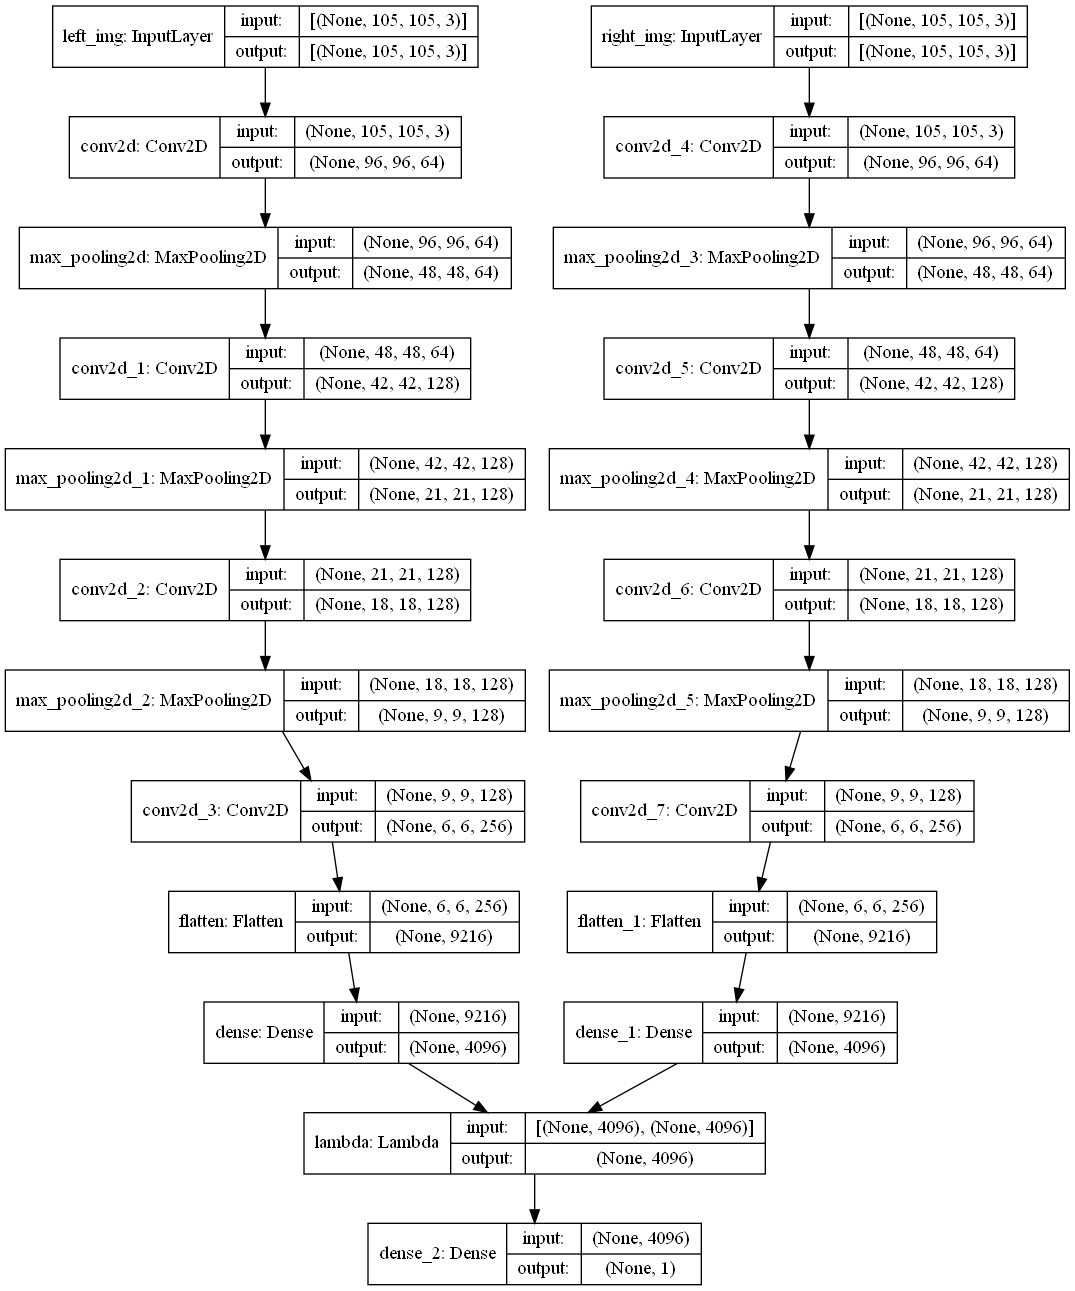

In [17]:
model = siamese_networks(input_shape)
keras.utils.plot_model(model, "siamese_networks.png", show_shapes=True)

In [18]:
model.summary()

Model: "siamese_networks"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
left_img (InputLayer)           [(None, 105, 105, 3) 0                                            
__________________________________________________________________________________________________
right_img (InputLayer)          [(None, 105, 105, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 96, 96, 64)   19264       left_img[0][0]                   
__________________________________________________________________________________________________
conv2d_4 (Conv2D)               (None, 96, 96, 64)   19264       right_img[0][0]                  
___________________________________________________________________________________

In [19]:
model.compile(
    loss=triplet_loss,
    optimizer=keras.optimizers.SGD(),
    metrics=["accuracy"],
)


In [20]:
history = model.fit(
    ds_train,
    epochs=6,
    # validation_data=[ds_test, ds_test],
)

Epoch 1/6


ValueError: in user code:

    C:\Users\mithr\miniconda3\lib\site-packages\keras\engine\training.py:853 train_function  *
        return step_function(self, iterator)
    C:\Users\mithr\miniconda3\lib\site-packages\keras\engine\training.py:842 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    C:\Users\mithr\miniconda3\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:1286 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    C:\Users\mithr\miniconda3\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2849 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    C:\Users\mithr\miniconda3\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:3632 _call_for_each_replica
        return fn(*args, **kwargs)
    C:\Users\mithr\miniconda3\lib\site-packages\keras\engine\training.py:835 run_step  **
        outputs = model.train_step(data)
    C:\Users\mithr\miniconda3\lib\site-packages\keras\engine\training.py:787 train_step
        y_pred = self(x, training=True)
    C:\Users\mithr\miniconda3\lib\site-packages\keras\engine\base_layer.py:1020 __call__
        input_spec.assert_input_compatibility(self.input_spec, inputs, self.name)
    C:\Users\mithr\miniconda3\lib\site-packages\keras\engine\input_spec.py:199 assert_input_compatibility
        raise ValueError('Layer ' + layer_name + ' expects ' +

    ValueError: Layer siamese_networks expects 2 input(s), but it received 1 input tensors. Inputs received: [<tf.Tensor 'IteratorGetNext:0' shape=(None, 2, 105, 105, 3) dtype=float32>]
